## Introduction

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.

In this notebook, we'll be building a simple regression model to predict hourly bike rentals using a popular dataset. There are two goals for this notebook:

1. Show how XGBoost can be used to build a regression model
2. Describe various SHAP visualizations we can build to understand our model

## Background

This dataset contains daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The goal is to predict how many bikes will be rented depending on the weather and the day. The data can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

Features available in the dataset: 

- Count of bicycles including both casual and registered users. The count is used as the target in the regression task.
- The season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year, either 2011 or 2012.
- The hour of day : 0 to 23
- Number of days since the 01.01.2011 (the first day in the dataset).
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
    - clear, few clouds, partly cloudy, cloudy
    - mist + clouds, mist + broken clouds, mist + few clouds, mist
    - light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds
    - heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celsius.
- Relative humidity in percent (0 to 100).
- Wind speed in km per hour.

## Preparation and imports

This notebook was created and tested on an ml.m5.2xlarge notebook instance.

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [2]:
bucket = 'xgboost-beta-2'
prefix = 'sagemaker/DEMO-xgboost-bike'
 
# Define IAM role: automatically get the role if run on a SageMaker instance
import boto3
import re
from sagemaker import get_execution_role

# role = get_execution_role()
role = "arn:aws:iam::398557468931:role/service-role/AmazonSageMaker-ExecutionRole-20190626T094141"

#region = boto3.Session().region_name
region = 'us-west-2'

In [3]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import pickle as pkl                              # For serializing/deserializing model
import sagemaker                                  # Amazon SageMaker's Python SDK provides many helper functions
import os                                         # For manipulating filepath names
from sklearn.model_selection import train_test_split   # For splitting the dataset

## Data

Let's start by downloading the dataset from UCI's ML Repository.

In [4]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
!unzip -o Bike-Sharing-Dataset.zip

--2019-09-10 11:55:20--  http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip.1’

Bike-Sharing-Datase 100%[===================>] 273.43K  --.-KB/s    in 0.1s    

2019-09-10 11:55:21 (2.30 MB/s) - ‘Bike-Sharing-Dataset.zip.1’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


In [5]:
data = pd.read_csv('hour.csv')
print(data.shape)
data.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Transformations

1. Replace column names with meaningful names
2. One-hot encode categorical columns

In [6]:
data.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'hum': 'humidity',
                     'cnt':'count'},
            inplace=True)
data = data.drop(['registered', 'casual', 'instant','dteday','yr'], axis=1)

categorical_columns = ['season', 'month', 'hour', 'holiday', 'weekday', 'weather']
categorical_col_values = {'season': ['spring', 'summer', 'fall', 'winter'], 
                          'month': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
                          'hour': range(24), 
                          'holiday': ['no', 'yes'], 
                          'weekday': ['sun', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat'], 
                          'weather': ['clear', 'mist', 'snow', 'rain']}

data_dummy = pd.get_dummies(data, prefix=categorical_columns, columns=categorical_columns, drop_first=True)
data_dummy.head()

,workingday,temp,atemp,humidity,windspeed,count,season_2,season_3,season_4,month_2,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,0,0.24,0.2879,0.81,0.0,16,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0.22,0.2727,0.80,0.0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0.22,0.2727,0.80,0.0,32,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0.24,0.2879,0.75,0.0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0.24,0.2879,0.75,0.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [7]:
y = data_dummy.loc[:, "count"]
X = data_dummy.drop("count", axis=1)
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

pd.concat([y_train, X_train], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([y_test, X_test], axis=1).to_csv('test.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'data/test.csv')).upload_file('test.csv')

## Training

In [14]:
# Open Source distributed script mode
from sagemaker.session import s3_input, Session
from sagemaker.xgboost.estimator import XGBoost

# use validation set to choose # of trees
hyperparams = {
    "eta": 0.2,
    "max_depth": 3, 
    "subsample": 0.5, 
    "verbose": 0, 
    'num_round': 1000
}

instance_type = "ml.c5.2xlarge"
output_path = 's3://{}/{}'.format(bucket, prefix)
content_type = "csv"
train_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, 'data/train.csv'), content_type=content_type)
validation_input = s3_input("s3://{}/{}/{}".format(bucket, prefix, 'data/test.csv'), content_type=content_type)

In [ ]:
boto_session = boto3.Session(region_name=region)
session = Session(boto_session=boto_session)
script_path = 'bikeshare-script.py'

xgb_script_mode_estimator = XGBoost(
    entry_point=script_path,
    framework_version='0.90-1', # Note: framework_version is mandatory
    hyperparameters=hyperparams,
    role=role,
    train_instance_count=1, 
#     train_instance_type=instance_type,
    train_instance_type='local',
    output_path=output_path)

xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input})

In [16]:
from urllib.parse import urlparse
filepath = urlparse(xgb_script_mode_estimator.model_data, allow_fragments=False).path.lstrip('/')
client = boto3.client('s3')
client.download_file(bucket, filepath, 'model.tar.gz')

In [17]:
!tar -xvf model.tar.gz

x xgboost-model


## Explaining the model using SHAP

We use SHAP values as means to understand the contributions of the features to the model predictions. SHAP (SHapley Additive exPlanations) by Lundberg and Lee (2016) is a method to
explain individual predictions and is based on the game theoretically optimal
Shapley Values.

A prediction can be explained by assuming that each feature value of the
instance is a “player” in a game where the prediction is the payout. Shapley
values – a method from coalitional game theory – tells us how to fairly
distribute the “payout” among the features.

**Be careful to interpret the Shapley value correctly**: The Shapley value is the
average contribution of a feature value to the prediction in different
coalitions. The Shapley value is NOT the difference in prediction when we would
remove the feature from the model.

Reference: "Explainable machine-learning predictions for the prevention of hypoxaemia during surgery", Nature Biomedical Engineering, 2018

In [18]:
import shap
shap.initjs()

model = pkl.load(open('xgboost-model', 'rb'))
# shap_values = pkl.load(open('shap-values', 'rb'))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

[12:05:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


A global aggregation of the individual Shapley values gives the overall average contributions of the features. The plot below shows that `temp` plays an important role in number of bikes rented. Similarly, the time of day (specifically, morning and evening rush hours) also play a pivotal role is predicting the number of bikes rented an hour. 

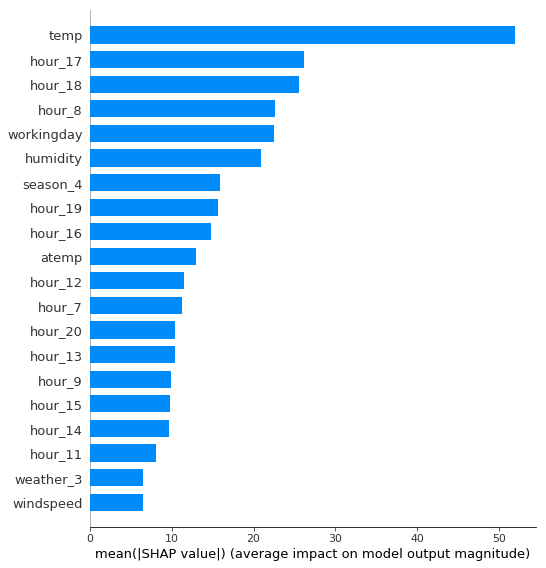

In [19]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

The **summary plot** below can provide more context over the bar chart of feature importances. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high `temp` leads to more bike rentals while higher `humidity` leads to reduction in count).

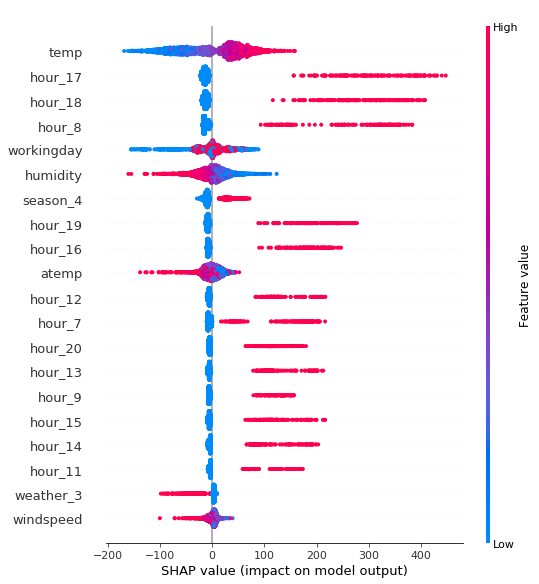

In [20]:
shap.summary_plot(shap_values, X_test)

A **SHAP dependence plot** shows how the model output varies by feature value while showing the interaction between two features. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. 

The plot below indicates that interaction between `temp` and `humidity`. As temperatures increase, the SHAP values increase which implies that bikes are rented more on hotter days/hours. For any particular temperature, increase in humidity leads to lower bike rentals as indicated by the color in any column of `temp`. 

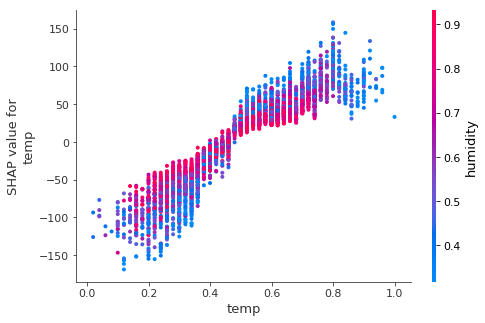

In [21]:
shap.dependence_plot("temp", shap_values, X_test)

Below **dependence plot** shows that, in general, presence of `hour_8` (i.e. at 8 am) bike rental counts are higher than the average. Further, this effect is, expectedly, higher on a working day (red color in the plot). 

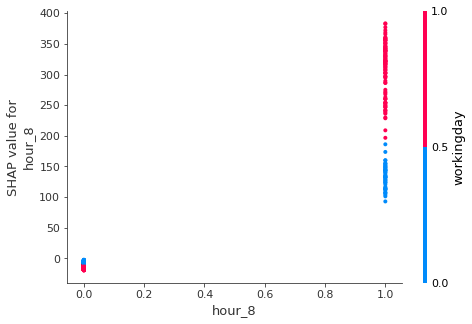

In [22]:
shap.dependence_plot("hour_8", shap_values, X_test)

A **force plot** explanation shows how features are contributing to push the model output from the base value (the average model output over the dataset) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue 

Plot below indicates that for this particular data point the prediction (232.27) is higher than the average (190.1) primarily because this is 9 am on a hot (`temp=0.7`, approx 25 C) summer day. The fact that it's not a working day reduces the count. 

In [23]:
shap.force_plot(explainer.expected_value, shap_values[100, :], X_test.iloc[100, :])

Similary, for the data point below, the prediction (51.52) is much lower than average because it's 5 am with `temp=0.36` (approx 10 C). 

In [24]:
shap.force_plot(explainer.expected_value, shap_values[1000, :], X_test.iloc[1000, :])

## Appendix (delete before publishing)

In [26]:
import seaborn as sn                              # Seaborn visualization library
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs


[Text(0.5, 1.0, 'Use of the system during weekdays and weekends')]

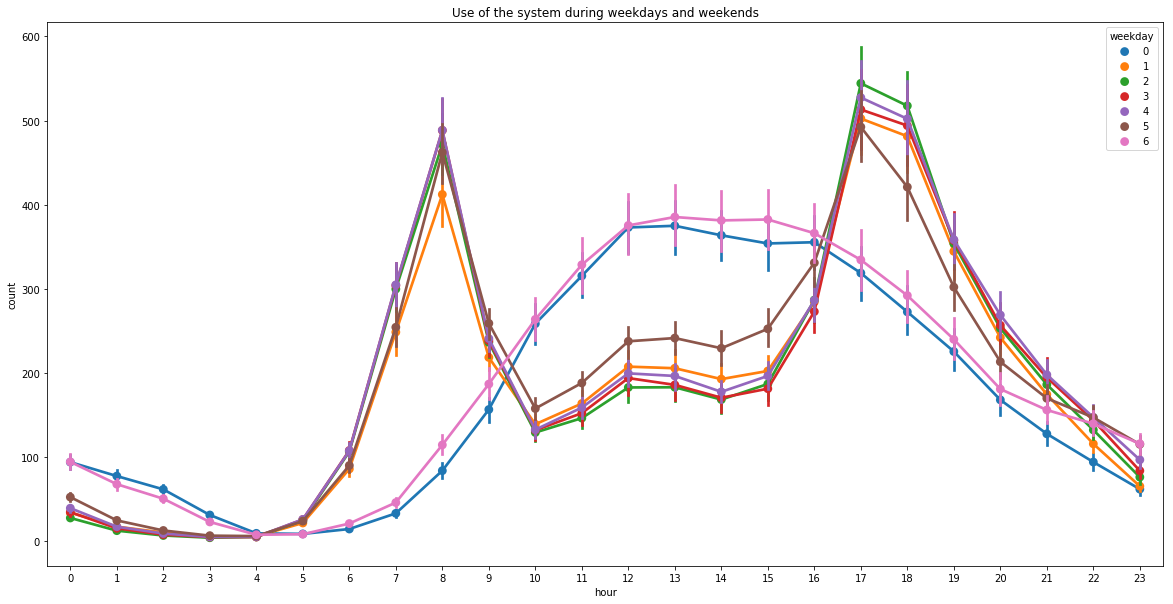

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
sn.pointplot(data=data[['hour',
                       'count',
                       'weekday']],
            x='hour', y='count',
            hue='weekday', ax=ax)
ax.set(title="Use of the system during weekdays and weekends")

[Text(0.5, 1.0, 'Monthly distribution')]

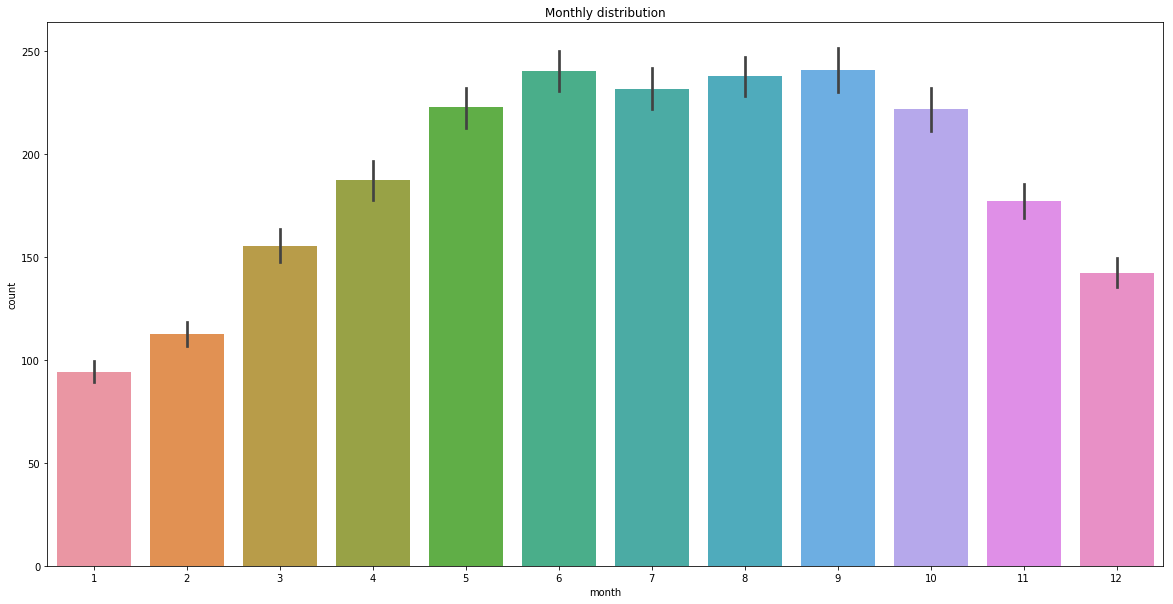

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
sn.barplot(data=data[['month',
                      'count']],
            x='month', y='count')
ax.set(title="Monthly distribution")

In [ ]:
import xgboost

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

# use validation set to choose # of trees
params = {
    "eta": 0.02,
    "max_depth": 3, 
    "subsample": 0.5, 
    "verbose": 1
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_full, 5000)

[0]	test-rmse:257.691


/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1000]	test-rmse:79.9355
[2000]	test-rmse:74.4079
[3000]	test-rmse:72.3413
[4000]	test-rmse:71.1764
[5000]	test-rmse:70.3585
[6000]	test-rmse:69.9794
